### Import libraries 

In [1]:
import cv2 as OpenCV
import numpy as np
import os
from matplotlib import pyplot as plt

### Helper functions


In [2]:
def displayImage(image, title = None):
    if image.ndim == 2:
        plt.gray()
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.show()

# OpenCV use BGR format for reading images as it's default 
# to get RGB images we need to change the format 
def readImageRGB(imagePath):
    return OpenCV.cvtColor(OpenCV.imread(imagePath), OpenCV.COLOR_BGR2RGB)

def RGBtoGRAY(images):
    grayImages = []
    for image in images: 
        grayImages.append(OpenCV.cvtColor(image, OpenCV.COLOR_RGB2GRAY))
    return grayImages

### Read all images from file into an array: images

In [3]:
def readImages(folderPath):
    files = sorted(os.listdir(folderPath))
    images = []
    for file in files:
    # Read only images of format jpg
        if ".jpg" in file:
            images.append(readImageRGB(folderPath + "/" + file))
    return images

images = readImages("Images")


### Get gray images

In [4]:
grayImages = RGBtoGRAY(images)

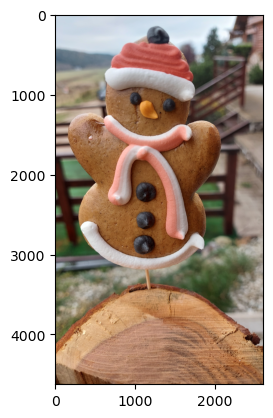

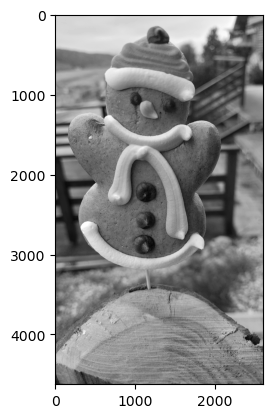

In [5]:
displayImage(images[0])
displayImage(grayImages[0])

## Feature Extraction
### Get **SIFT** keypoints & descriptors on single image

In [6]:
SIFT = OpenCV.SIFT_create()

def getSiftKeypoints(imageIndex):
    keyPoint, descriptor = SIFT.detectAndCompute(grayImages[imageIndex], None)
    return keyPoint, descriptor

### Get **MSER** keypoints & descriptors on all images

In [36]:
MSER = OpenCV.MSER_create()

def getMserKeypoints(imageIndex):
    keyPoint = MSER.detect(grayImages[imageIndex], None)
    descriptor = MSER.compute(grayImages[imageIndex], keyPoint)
    return keyPoint, descriptor

### Draw the keypoints 

In [ ]:
def drawKeypoints(images, grayImages, keyPoints, method = "SIFT"):
    for i in range(len(images)):
        img = OpenCV.drawKeypoints(grayImages[i], keyPoints[i], images[i], flags = OpenCV.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
        OpenCV.imwrite("keyPoints/"+method+"/"+str(i)+".jpg", img)

### Get keypoints & descriptors for all images

In [7]:
def getAllImagesKeyPoints (images, method = "SIFT"):
    keyPoints = []
    descriptors = []
    for i in range(0,len(images)):
        if method == "SIFT":
            keyPoint, descriptor = getSiftKeypoints(i)
        elif method == "MSER":
            keyPoint, descriptor = getMserKeypoints(i)
        keyPoints.append(np.array(keyPoint))
        descriptors.append(np.array(descriptor))
    return keyPoints, descriptors


### SIFT keypoints & descriptors on all images

In [8]:
SkeyPoints, Sdescriptors = getAllImagesKeyPoints(images, "SIFT")

### ⛔️ MSER keypoints & descriptors on all images
still have error in this part (most likely due to the gpu type used )
try to run it on a different machine

In [ ]:
MkeyPoints, Mdescriptors = getAllImagesKeyPoints(images, "MSER")


### Draw keypoints for all images (SIFT)

In [11]:
if (not os.path.exists("keyPoints")):
    os.mkdir("keyPoints")
if (not os.path.exists("keyPoints/SIFT")):
    os.mkdir("keyPoints/SIFT")

drawKeypoints(images, grayImages, SkeyPoints, "SIFT")

### ⛔️ Draw keypoints for all images (MSER)


In [45]:
if (not os.path.exists("keyPoints")):
    os.mkdir("keyPoints")
if (not os.path.exists("keyPoints/MSER")):
    os.mkdir("keyPoints/MSER")

# drawKeypoints(images, grayImages, MkeyPoints, "MSER")

## Image Matching

In [9]:
allDescriptors = []
for descriptors in Sdescriptors:
    for descriptor in descriptors:
        allDescriptors.append(descriptor)


allDescriptors = np.stack(allDescriptors)

### Create clusters from descriptors using **Kmeans** 
#### don't run this, load the file only


In [ ]:
from scipy.cluster.vq import kmeans

clusters = 400
iter = 2
centroids, variance = kmeans(allDescriptors, clusters, iter)

### Save the centroids for later use intstead of training multiple times


In [14]:
import joblib
joblib.dump((clusters,centroids), "centroids.pkl", compress = 3)

['centroids.pkl']

### Load the file that stores the centroids


In [10]:
import joblib
clusters, centroids = joblib.load("centroids.pkl")

### Create the visualWords 
⛔️ Make sure to run **getSiftKeypoints** first

In [11]:
from scipy.cluster.vq import vq

visualWords = []
for descriptors in Sdescriptors:
    words, _ = vq(descriptors, centroids)
    visualWords.append(words)

### Calculate the frequency of each word

In [12]:
frequency_vectors = []
for img_words in visualWords:
    histogram = np.zeros(clusters)
    for word in img_words:
        histogram[word] += 1
    frequency_vectors.append(histogram)

frequency_vectors = np.stack(frequency_vectors)

### Plot the frequency of words

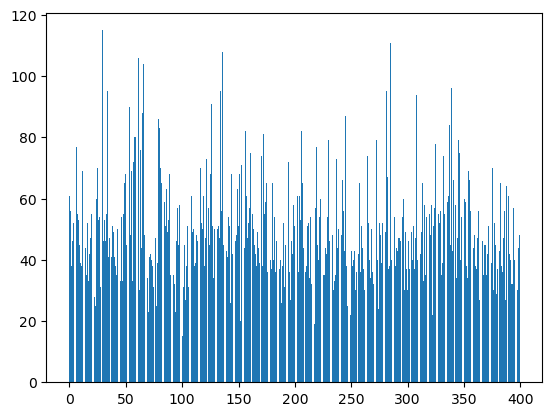

In [ ]:
plt.bar(list(range(clusters)), frequency_vectors[171])
plt.show()

### **TFIDF**: get the visual words that does that most effect

In [13]:
n = len(images)

df = np.sum(frequency_vectors > 0, axis = 0)
idf = np.log(n/df)
tfidf = frequency_vectors * idf

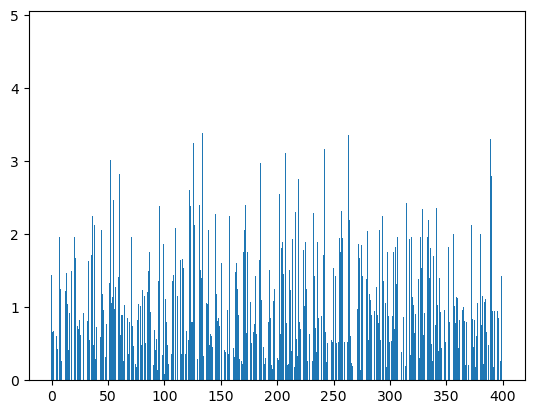

In [20]:
plt.bar(list(range(clusters)), tfidf[100])
plt.show()

### Scoring and searching for image matches

In [14]:
from numpy.linalg import norm
b = tfidf
def search_display(i: int, top_clusters: int = 5):

    print("Search image:")
    # show the search image
    displayImage(images[i])
    print("-----------------------------------------------------")  
    # evaluate the scores and get > 0.94
    a = tfidf[i]
    cosine_similarity = np.dot(a, b.T)/(norm(a) * norm(b, axis=1))
    idx = np.where(cosine_similarity > 0.94)[0]
    highestCos = cosine_similarity[(cosine_similarity > 0.94)][:len(idx)]
    # sort the idx based on the cosine_similarity
    idx = idx[np.argsort(-highestCos)]
    # remove the first index which is the search image
    if (top_clusters < len(idx)):
         idx = idx[1:top_clusters + 1]
    else:
        idx = idx[1:]
    # display the images       
    for i in idx:
        print(str(i)+": " + str(cosine_similarity[i]))
        displayImage(images[i])

In [15]:
b = tfidf
def search(i: int, top_clusters: int = 5):
     
    # evaluate the scores and get > 0.94
    a = tfidf[i]
    cosine_similarity = np.dot(a, b.T)/(norm(a) * norm(b, axis=1))
    idx = np.where(cosine_similarity > 0.94)[0]
    highestCos = cosine_similarity[(cosine_similarity > 0.94)][:len(idx)]
    # sort the idx based on the cosine_similarity
    idx = idx[np.argsort(-highestCos)]
    # remove the first index which is the search image
    if (top_clusters < len(idx)):
         idx = idx[1:top_clusters + 1]
    else:
        idx = idx[1:]
    return idx

Search image:


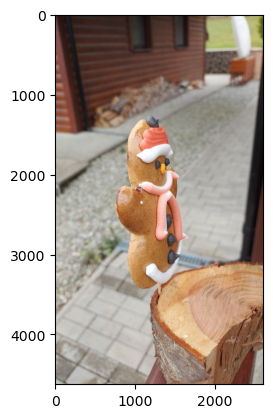

-----------------------------------------------------
99: 0.9645615256161834


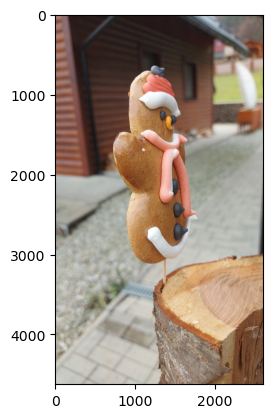

0: 0.9562378095025897


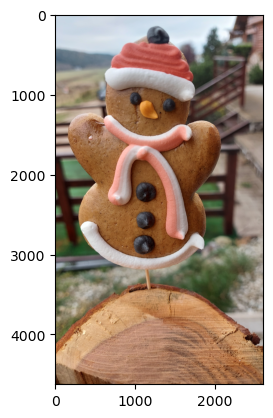

20: 0.9518174784781526


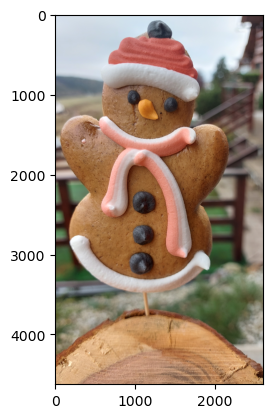

19: 0.9512201777825954


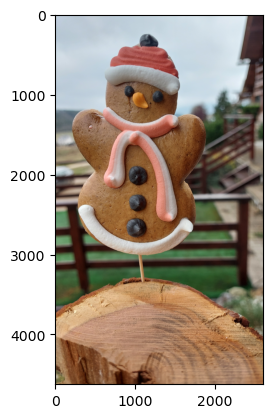

2: 0.9499008167897939


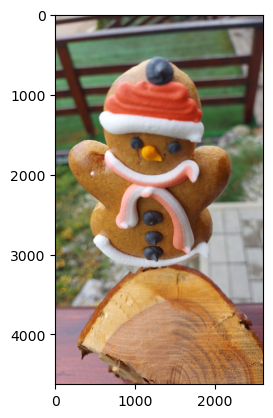

1: 0.9485011510157338


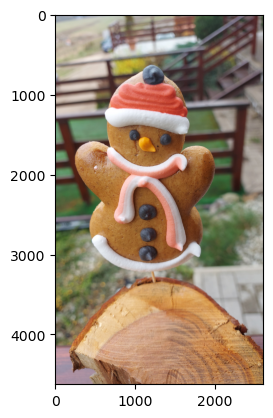

101: 0.9473829687803834


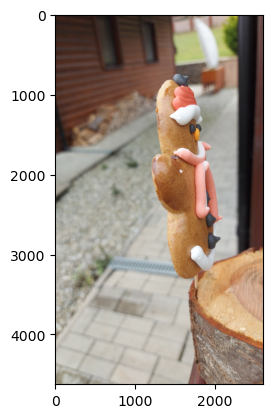

91: 0.9472036739040451


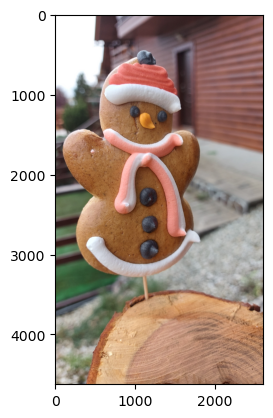

4: 0.9466759006953861


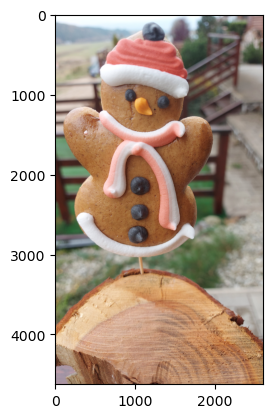

98: 0.9449016027181213


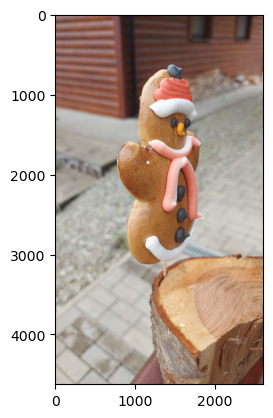

In [16]:
search_display(10,10)

### Get the best 10 matches for all images

In [17]:
matchesIDs = [search(i, 10) for i in range(len(images))]

In [18]:
print(matchesIDs[1])

[  2   0  19   4  20  23  98  99  15 143]


## Feature Matching
### Get the matching features between 2 images

In [19]:
matcher = OpenCV.BFMatcher()
def featureMatching(imgID1, imgID2, Sdescriptors):
    matches = matcher.match(Sdescriptors[imgID1], Sdescriptors[imgID2])
    return matches


In [20]:
match = featureMatching(0,1,Sdescriptors)

## Match all images features

In [21]:
import multiprocessing

num_cores = multiprocessing.cpu_count()
print(f"Number of CPU cores: {num_cores}")


Number of CPU cores: 8


In [22]:
def dataFeatureMatching (matchesIDs, Sdescriptors):
    checker = np.zeros((len(Sdescriptors), len(Sdescriptors))).astype(bool)
    dataMatches = []
    for imageID in range(len(matchesIDs)):
        for matchedID in matchesIDs[imageID]:
            if ((checker[imageID][matchedID] == False or checker[matchedID][imageID] == False)):
                dataMatches.append([imageID, matchedID, featureMatching(imageID, matchedID, Sdescriptors)])
                checker[imageID][matchedID] = True
                checker[matchedID][imageID] = True
            print ("done: " + str(imageID)+ " " + str(matchedID))
    return dataMatches

# featuresMatches = dataFeatureMatching(matchesIDs, Sdescriptors)

#### Parallelized implementation of feature matching

In [24]:
import time
import logging
def add_match(args):
    imageID, matchedID, Sdescriptors = args
    if ((checker[imageID][matchedID] == False)):
        match = featureMatching((imageID, matchedID, Sdescriptors))
        checker[matchedID][imageID] == True
        checker[imageID][matchedID] == True
        logging.info(f"Match found: {imageID} {matchedID}")
        return [imageID, matchedID, match]
    else:
        logging.info(f"Match already found: {imageID} {matchedID}")
        return None

In [25]:
from multiprocessing import Pool

def dataFeatureMatchingParallelized(matchesIDs, Sdescriptors, num_processes=6, timeout=15):
    global checker
    checker = np.zeros((len(Sdescriptors), len(Sdescriptors))).astype(bool)
    dataMatches = []
    
    with Pool(processes=num_processes) as p:
        args = [(imageID, matchedID, Sdescriptors) for imageID in range(len(matchesIDs)) for matchedID in matchesIDs[imageID]]
        results = []
        for arg in args:
            result = p.apply_async(add_match, args=(arg,))
            results.append(result)
        
        for i, result in enumerate(results):
            try:
                match = result.get(timeout=timeout)
                if match is not None:
                    dataMatches.append(match)
            except:
                print(f"Timeout: {i}")

    return dataMatches

In [26]:
featureMatching = dataFeatureMatchingParallelized(matchesIDs, Sdescriptors, num_processes=6, timeout=15)

Timeout: 0
Timeout: 1
Timeout: 2
Timeout: 3
Timeout: 4
Timeout: 5
Timeout: 6
Timeout: 7
Timeout: 8
Timeout: 9
Timeout: 10
Timeout: 11
Timeout: 12
Timeout: 13
Timeout: 14
Timeout: 15
Timeout: 16
Timeout: 17
Timeout: 18
Timeout: 19
Timeout: 20
Timeout: 21
Timeout: 22
Timeout: 23
Timeout: 24
Timeout: 25
Timeout: 26
